In [1]:
%pylab inline --no-import-all
import cv2
import keras
import tensorflow as tf
from keras.layers import *
from keras.models import Sequential, Model
import keras.backend as K
import sys
import os
import skimage
import skimage.transform
import skimage.exposure

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


(25, 100)


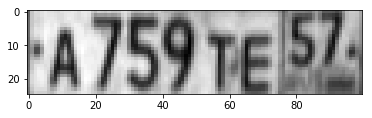

In [2]:
sample_img = cv2.cvtColor(plt.imread(os.path.join("data/rus/segmentation/src/", os.listdir("data/rus/segmentation/src")[0])),
                          cv2.COLOR_RGBA2GRAY)
plt.imshow(sample_img, cmap='gray')
print(sample_img.shape)

In [3]:
input_dim = (25, 100, 1)
output_dim = (1, 100, 1)
image_area = input_dim[0] * input_dim[1]

In [109]:
def train_data_gen(srcPath, dstPath, inputDim, outputDim, batchSize=100):
    srcs = np.zeros((batchSize, *inputDim))
    dsts = np.zeros((batchSize, *outputDim))
    
    for idx, src_node in enumerate(os.scandir(srcPath)):
        i = idx % batchSize
        src = cv2.cvtColor(plt.imread(src_node.path), cv2.COLOR_RGBA2GRAY)
        dst = cv2.cvtColor(plt.imread(os.path.join(dstPath, src_node.name)), cv2.COLOR_RGBA2GRAY)
        srcs[i, :] = src.reshape(inputDim)
        dsts[i, :] = dst.reshape(outputDim)
        if len(srcs) == batchSize:
            yield srcs, dsts
    yield srcs, dsts

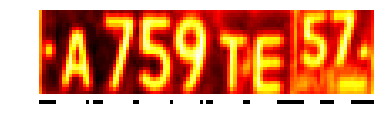

In [110]:
src_path = "data/rus/segmentation/src/"
dst_path = "data/rus/segmentation/dst/"

for X, Y in train_data_gen(src_path, dst_path, input_dim, output_dim, batchSize=1):
    src = X
    dst = Y
    plt.subplot(211)
    plt.imshow(src.reshape(input_dim[:2]), cmap='hot_r')
    plt.axis("off")
    plt.subplot(212)
    plt.imshow(dst.reshape(output_dim[:2]), cmap='gray')
    plt.axis("off")
    plt.subplots_adjust(hspace=-0.7)
    break

In [111]:
from keras.objectives import binary_crossentropy

first_layer_filters = 64
second_layer_filters = 32
third_layer_filters = 32

# sess = tf.Session()
# K.set_session(sess)

# inp = tf.placeholder(tf.float32, shape=(None, *input_dim))
# out = tf.placeholder(tf.float32, shape=(None, *output_dim))

# conv = Conv2D(first_layer_filters, (13, 1), activation='relu', name='conv1')(inp)
# conv = Conv2D(second_layer_filters, (9, 1), activation='relu', name='conv2')(conv)
# conv = Conv2D(third_layer_filters, (1, 21), activation='relu', padding='same', name='conv3')(conv)
# conv = ZeroPadding2D(padding=(0, 2))(conv)
# conv = Conv2D(1, (5, 5), name='conv_last')(conv)
# preds = tf.sigmoid(conv)
    
# correct = tf.equal(preds > 0.5, out > 0.5)
# accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# loss = tf.reduce_mean(K.binary_crossentropy(out, preds))

# train_step = tf.train.AdamOptimizer().minimize(loss)

# init_op = tf.global_variables_initializer()
# sess.run(init_op)

model = Sequential([
    Conv2D(first_layer_filters, (17, 1), input_shape=input_dim, activation='relu', name='conv1'),
    #Conv2D(second_layer_filters, (9, 1), activation='relu', name='conv2'),
    ZeroPadding2D(padding=(0, 10)),
    Conv2D(third_layer_filters, (5, 21), activation='relu', padding='valid', name='conv3'),
    ZeroPadding2D(padding=(0, 2)),
    Conv2D(1, (5, 5), activation='sigmoid', name='conv_last')
])

model.compile('adam', 'binary_crossentropy', metrics=['binary_accuracy'])

In [113]:
from progressbar import FormatCustomText, ProgressBar, Counter, Bar

def train(dataset, batch_size=10, epochs=1):
    src_path = f"data/{dataset}/segmentation/src/"
    dst_path = f"data/{dataset}/segmentation/dst/"

    train_count = len(os.listdir(dst_path))
    train_batches = train_count // batch_size

    model.fit_generator(train_data_gen(src_path, dst_path, input_dim, output_dim, batch_size), steps_per_epoch=train_batches)
    return
    for epoch in range(epochs):
        counter = Counter()
        text = FormatCustomText('loss: %(loss).6f, acc: %(acc).6f', mapping={"loss": 1, "acc": 0})
        progress = ProgressBar(widgets=['[' , counter, '/' , str(train_batches), '] ', Bar(), text], 
                               min_value = 1,
                               max_value=train_batches,
                               marker='-')

        with sess.as_default():
            for x, y in progress(train_data_gen(src_path, dst_path, input_dim, output_dim, batch_size)):
                _, loss_value, acc_value = sess.run([train_step, loss, accuracy], feed_dict={inp: X, out: Y})
                text.update_mapping(loss=loss_value, acc=acc_value)

    
train("rus", 10, 1)
#train("bel", 10, 1)

Epoch 1/1
121/121 [==============================] - 14s - loss: 0.3511 - binary_accuracy: 0.8343    


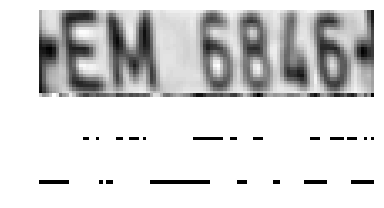

In [117]:
def plot_predictions(dataset):
    src_path = f"data/{dataset}/segmentation/src"
    dst_path = f"data/{dataset}/segmentation/dst"
    
    filename = os.listdir(src_path)[10]
    
    src = cv2.cvtColor(plt.imread(os.path.join(src_path, filename)), cv2.COLOR_RGBA2GRAY)
    src_reshaped = src.reshape((1, *input_dim))
    dst = cv2.cvtColor(plt.imread(os.path.join(dst_path, filename)), cv2.COLOR_RGBA2GRAY)
    dst_reshaped = dst.reshape((1, *output_dim))

    predicted = sess.run(preds, feed_dict={inp: src_reshaped})
    #predicted = model.predict(src_reshaped)
    acc = sess.run(accuracy, feed_dict={inp: src_reshaped, out: dst_reshaped})

    plt.subplot(411)
    plt.imshow(src, cmap='gray')
    plt.axis("off")
    plt.subplot(412)
    plt.imshow(predicted.reshape(output_dim[:2]) * 255, cmap='gray')
    plt.axis("off")
    plt.subplot(413)
    plt.axis("off")
    plt.imshow(np.where(predicted > 0.5, 1, 0).reshape(output_dim[:2]), cmap='gray')
    plt.subplot(414)
    plt.axis("off")
    plt.imshow(dst, cmap='gray')
    plt.subplots_adjust(hspace=-0.5)
    

plot_predictions("bel")

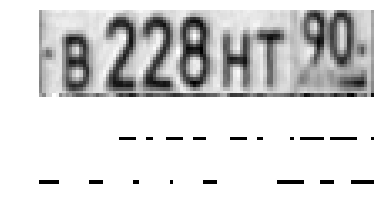

In [119]:
plot_predictions("rus")